In [1]:
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({"text.usetex": False,
                     "font.size": 22,
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})

In [3]:
df = pd.read_csv("../measurements/JPEG_manager_dyanmic2/characteristic.csv")

In [4]:
df.head()

,pruning_thresh,quality,technique,bandwidth,mAP_drop,frame_id,sparsity,decomposability,regularity,pictoriality,datasize_est,datasize_real,reconstruct_snr,target_cmp,target_snr
0,0.05,92,1,2.498029e+07,40,1,-1,-1,-1,-1,38398,39142,13.467377,18.473873,20
1,0.05,92,1,2.492123e+07,40,2,-1,-1,-1,-1,28669,29413,19.505306,18.517654,20
2,0.05,92,1,2.482305e+07,40,3,-1,-1,-1,-1,27481,28225,23.767583,18.590892,20
3,0.05,92,1,2.468615e+07,40,4,-1,-1,-1,-1,19647,20391,23.742502,18.693992,20
4,0.05,92,1,2.451106e+07,40,5,-1,-1,-1,-1,10792,11536,22.784839,18.827530,20


In [5]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")

In [6]:
tensor_size = 128*26*26*4
df["cmp"] = tensor_size/df["datasize_real"]

In [7]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 3

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps


thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
snr_m = df["reconstruct_snr"].to_numpy()

est_err3 = []
est_3 = []
est_err3_per=[]

for i in range(len(thresh)):
    sample_points = list(snr_samples.keys())
    sample_snrs = np.mean(np.array(list(snr_samples.values())),axis=1)
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_3.append(snr_est)
    est_err3.append(snr_est-snr_m[i])
    est_err3_per.append(abs((snr_est-snr_m[i])/snr_m[i]*100))

    try:
        values = snr_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = snr_m[i]
        snr_samples[(thresh[i],quality[i])] = values
    except:
        snr_samples[(thresh[i],quality[i])] = np.ones(window_size)*snr_m[i]


print(np.array(est_err3).mean())
print(np.array(est_err3).std())
print(np.array(est_err3_per).mean())

-0.9449417615565257
2.1946369329668074
9.470037565651316


In [8]:
np.percentile(np.array(est_err3_per[100:]), 80)

13.088428024407937

In [9]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 6

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps


thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
snr_m = df["reconstruct_snr"].to_numpy()

est_err6 = []
est_6 = []
est_err6_per=[]

for i in range(len(thresh)):
    sample_points = list(snr_samples.keys())
    sample_snrs = np.mean(np.array(list(snr_samples.values())),axis=1)
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_6.append(snr_est)
    est_err6.append(snr_est-snr_m[i])
    est_err6_per.append(abs((snr_est-snr_m[i])/snr_m[i]*100))

    try:
        values = snr_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = snr_m[i]
        snr_samples[(thresh[i],quality[i])] = values
    except:
        snr_samples[(thresh[i],quality[i])] = np.ones(window_size)*snr_m[i]

print(np.array(est_err6).mean())
print(np.array(est_err6).std())
print(np.array(est_err6_per).mean())

-1.0654211139308334
2.1525693171189086
9.822537344691908


In [10]:
np.percentile(np.array(est_err6_per),90)

20.776615310403205

In [11]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 9

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps


thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
snr_m = df["reconstruct_snr"].to_numpy()

est_err9 = []
est_9 = []
est_err9_per=[]

for i in range(len(thresh)):
    sample_points = list(snr_samples.keys())
    sample_snrs = np.mean(np.array(list(snr_samples.values())),axis=1)
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_9.append(snr_est)
    est_err9.append(snr_est-snr_m[i])
    est_err9_per.append(abs((snr_est-snr_m[i])/snr_m[i]*100))

    try:
        values = snr_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = snr_m[i]
        snr_samples[(thresh[i],quality[i])] = values
    except:
        snr_samples[(thresh[i],quality[i])] = np.ones(window_size)*snr_m[i]

print(np.array(est_err9).mean())
print(np.array(est_err9).std())
print(np.array(est_err9_per).mean())

-1.136629430861638
2.1878967355330783
10.137958823765961


In [12]:
np.percentile(np.array(est_err9_per), 90)

21.467520270524084

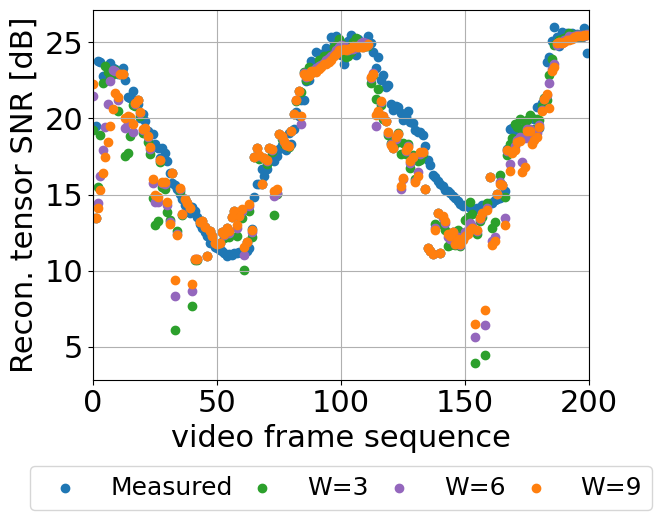

In [13]:
fig, ax1 = plt.subplots()
ax1.scatter(np.arange(200),snr_m,label ="Measured",color="tab:blue")
ax1.scatter(np.arange(200),est_3, label="W=3",color="tab:green")
ax1.scatter(np.arange(200),est_6, label="W=6",color="tab:purple")
ax1.scatter(np.arange(200),est_9, label="W=9",color="tab:orange")

ax1.legend(ncol=4,fontsize=18,loc="upper center",bbox_to_anchor=(0.5, -0.2), columnspacing=0.2)
ax1.grid()
ax1.set_ylabel("Recon. tensor SNR [dB]")
ax1.set_xlabel("video frame sequence")
ax1.set_xlim([0,200])
plt.savefig("./figures/snr_est.pdf",format="pdf", bbox_inches="tight")